Introduction
-----------------
This notebooks shows some features of the mm3dtestdata tools.

Usage
------

The mm3dtestdata is a set of routines that allow one to build a 3D dataset consisting of
- background (class 0)
- matrix (class 1)
- spheres (class 2)
- ellipsoids (class 3)

The spheres and ellipoids - balls and eggs -  are placed at random in a cube, and are embedded in a matrix.
The associated class maps can be used to compute multidimensional maps, for instance simulating workflows seen in X-ray tomography, X-ray fluoresence tomography or other spectral imaging approaches.

Overcoming challenges in data fusion, due to different modalities and spatial mismatches, algorithms are needed to overcome these issues. These routines allow one to build test data one which one can test drive new approaches.

Below, basic usage is demonstrated.

Note
-------
This code is not build to be ultra fast, and for some calculations one might spend a bit of time.
At present, thius is accpetable: the idea is to generate test data and have available ground truth data against which to validate ones algorithms.

In [1]:
import numpy as np
import mm3dtestdata as mm3d
import matplotlib.pyplot as plt

Model Parameters
-------------

Some parameters of note :

- scale: the size of the cubic grid
- border: only place objects further away from the border
- radius: the radius of the sphere and corresponding equal-volume ellipsoid

Some parameters that govern derived data

- shake_rmsd: shake the objects to get a slightly different object between modalities
- sigma_spectral: blurring factor for our 'spectral' data
- sigma_xct: blurring factor for our tomography data

In [2]:
scale = 64
border = 20
radius = 10

shake_rmsd = 2.0
sigma_sem = 1.0
sigma_xct = 3.0

Build the objects

In [3]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, )
_, instance_map_0, class_map_0 = obj.fill()

In [4]:
obj.perturb(shake=shake_rmsd, cut=None, erase=None)
_, instance_map_1, class_map_1 = obj.fill()
obj.reset()

Build class maps. Class labels are turned into one-hot-vectors, and are Gaussian smeared.

In [5]:
class_map_semedx = mm3d.blur_it(class_map_0, sigma=sigma_sem)
class_map_xct = mm3d.blur_it(class_map_1, sigma=sigma_xct)

Show me

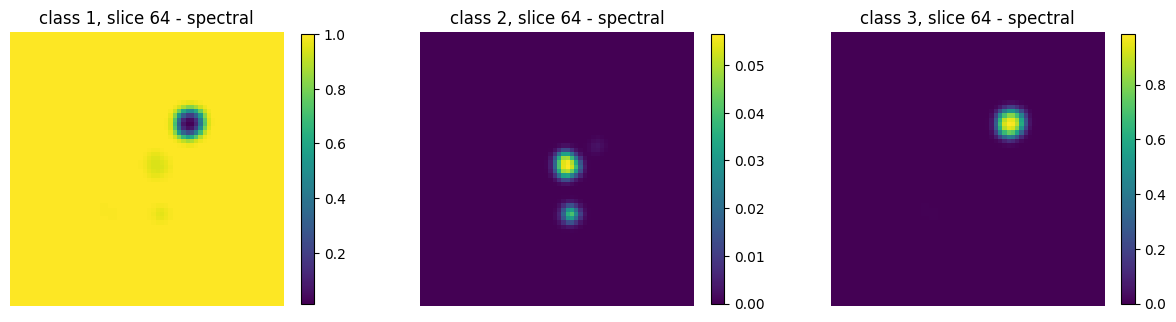

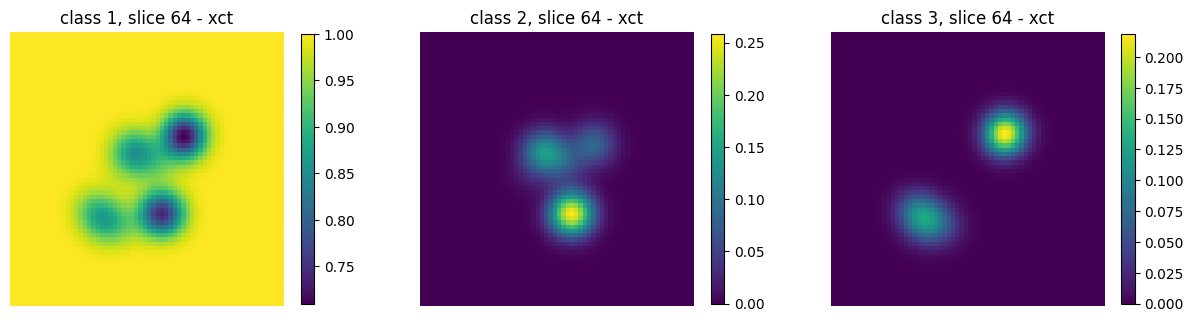

In [6]:

# Create a figure
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(class_map_semedx[1,scale//2,...])#, vmin=0, vmax = 1.0)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("class 1, slice 64 - spectral")

plt.subplot(1, 3, 2)
plt.imshow(class_map_semedx[2,scale//2,...])#, vmin=0, vmax = 1.0 )
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("class 2, slice 64 - spectral")


plt.subplot(1, 3, 3)
plt.imshow(class_map_semedx[3,scale//2,...])#, vmin=0, vmax = 1.0)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("class 3, slice 64 - spectral")
plt.show()



# Create a figure
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(class_map_xct[1,scale//2,...])#, vmin=0, vmax = 1.0)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("class 1, slice 64 - xct")

plt.subplot(1, 3, 2)
plt.imshow(class_map_xct[2,scale//2,...])#, vmin=0, vmax = 1.0 )
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("class 2, slice 64 - xct")


plt.subplot(1, 3, 3)
plt.imshow(class_map_xct[3,scale//2,...])#, vmin=0, vmax = 1.0)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("class 3, slice 64 - xct")
plt.show()


In [7]:
print(class_map_xct.shape)

(4, 64, 64, 64)


Define spectra and densities for each class and compute the weighted maps

In [8]:
tomo_map = mm3d.build_material_maps_XCT_SEM_EDX(class_map_xct, "VEQI")

(1, 4) (4, 64, 64, 64)
(4, 64, 64, 64) (1, 4)
(4, 64, 64, 64) (4, 4)


ValueError: too many values to unpack (expected 2)

In [ ]:
x = np.linspace(0,100,100)
spectral_class_0 = x*0
spectral_class_1 = x*0
spectral_class_2 = np.exp( -(x-20)**2 / (2.0*4.0**2) )
spectral_class_3 = 0.5*np.exp( -(x-25)**2 / (2.0*4.0**2) ) + 0.5*np.exp( -(x-75)**2 / (2.0*4.0**2) )
class_actions_spectral = np.column_stack([spectral_class_0,
                                        spectral_class_1,
                                        spectral_class_2,
                                        spectral_class_3]).T


tomo_class_0 = np.array([0])
tomo_class_1 = np.array([0.05])
tomo_class_2 = np.array([0.25])
tomo_class_3 = np.array([0.35])
class_actions_tomo = np.column_stack([tomo_class_0,
                                      tomo_class_1,
                                      tomo_class_2,
                                      tomo_class_3]).T



In [ ]:
plt.plot(x, spectral_class_0)
plt.plot(x, spectral_class_1)
plt.plot(x, spectral_class_2)
plt.plot(x, spectral_class_3)
plt.legend(["Class 0",
            "Class 1",
            "Class 2",
            "Class 3",
           ])
plt.title("Spectra")
plt.show()

plt.bar( ["Class 0", "Class 1", "Class 2", "Class 3"],class_actions_tomo.ravel() )
plt.title("Density")
plt.show()

We add noise as well to make life more interesting. Added noise consists of

$
(U_1^2+V_1^2)*\mathrm{factor*density} + (U_2^2+V_2^2)*\mathrm{dark_{factor}}
$

where U and V are Gaussian random variables wuith mean 0 and sigma 1.


In [ ]:
spectral_map = mm3d.compute_weighted_map(class_map_spectral, class_actions_spectral)
xct_map = mm3d.compute_weighted_map(class_map_xct, class_actions_tomo)

spectral_map = spectral_map + mm3d.noise(spectral_map, 0.05, 0.0)
xct_map = xct_map + mm3d.noise(xct_map, 0.01, 0.0)

Show me

In [ ]:

# Create a figure
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(spectral_map[20,64,...])#, vmin=0, vmax = 0.5)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("two-theta-bin 20, slice 64")

plt.subplot(1, 3, 2)
plt.imshow(spectral_map[50,64,...])#, vmin=0, vmax = 0.05)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("two-theta-bin 50, slice 64")


plt.subplot(1, 3, 3)
plt.imshow(spectral_map[70,64,...])#, vmin=0, vmax = 0.10)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("two-theta-bin 70, slice 64")

# Display the plot
plt.show()

# Create a figure
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(xct_map[0,64,...])#, vmin=0.05, vmax = 0.55)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("XCT, slice 64")

plt.subplot(1, 3, 2)
plt.imshow(xct_map[0,64,...])#, vmin=0.05, vmax = 0.55)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("XCT, slice 64")


plt.subplot(1, 3, 3)
plt.imshow(xct_map[0,64,...])#, vmin=0.05, vmax = 0.55)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("XCT, slice 64")

# Display the plot
plt.show()

Sometimes our experiment gives us slices of data from the volume. Here we show how we can slice our object.
We use interpolation in a plane, defined by a normal and a point. We control the correpsonding grid size by N and the step size.

We submit a full channel block and retrieve the slice defined by the parameters given.

In [ ]:
slicer = mm3d.schaaf(shape = class_map_0.shape)

plakje_spectral = slicer.plakje(normal=(0.25,0.70,1.0),
                                point = (64,64,64),
                                N=128,
                                spacing=1.0,
                                data=spectral_map)

plakje_xct = slicer.plakje(normal=(0.25,0.70,1.0),
                           point = (64,64,64),
                           N=128,
                           spacing=1.0,
                           data=xct_map)


In [ ]:
# Create a figure
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(plakje_spectral[15,...])#, vmin=0, vmax = 0.5)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("two-theta-bin 15, cut")

plt.subplot(1, 3, 2)
plt.imshow(plakje_spectral[25,...])#, vmin=0, vmax = 0.05)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("two-theta-bin 25, cut")


plt.subplot(1, 3, 3)
plt.imshow(plakje_spectral[70,...])#, vmin=0, vmax = 0.10)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("two-theta-bin 70, cut")

# Display the plot
plt.show()


# Create a figure
plt.figure(figsize=(3.65,3.65))
plt.imshow(plakje_xct[0])#, vmin=0, vmax = 0.5)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("XCT, cut")

plt.show()


We can also go off a cardinal direction and do some zooming in

In [ ]:
slicer = mm3d.schaaf(shape = class_map_0.shape)

plakje_spectral = slicer.plakje(normal=(0.25,0.70,1.0),
                                point = (30,40,50),
                                N=264,
                                spacing=0.1,
                                data=spectral_map, method="linear")

plakje_xct = slicer.plakje(normal=(0.25,0.70,1.0),
                           point = (30,40,50),
                           N=264,
                           spacing=0.1,
                           data=xct_map, method="linear")

In [ ]:
# Create a figure
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(plakje_spectral[15,...])#, vmin=0, vmax = 0.5)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("two-theta-bin 15, cut")

plt.subplot(1, 3, 2)
plt.imshow(plakje_spectral[25,...])#, vmin=0, vmax = 0.05)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("two-theta-bin 25, cut")


plt.subplot(1, 3, 3)
plt.imshow(plakje_spectral[70,...])#, vmin=0, vmax = 0.10)
plt.colorbar(shrink=0.70)
plt.axis('off')
plt.title("two-theta-bin 70, cut")

# Display the plot
plt.show()


# Create a figure
plt.figure(figsize=(3.65,3.65))
plt.imshow(plakje_xct[0])#, vmin=0, vmax = 0.5)
plt.colorbar(shrink=0.70)
plt.axis('off')  # Turn off axis numbers and labels
plt.title("XCT, cut")

plt.show()


In [ ]:

import napari
viewer = napari.view_image(spectral_map[20,50:-50,50:-50,50:-50])
_ = viewer.add_image(spectral_map[70,50:-50,50:-50,50:-50])
_ = viewer.add_labels(class_map_0[50:-50,50:-50,50:-50]-1)


In [ ]:
from skimage.measure import marching_cubes

In [ ]:
sm1 = marching_cubes(spectral_map[20,50:-50,50:-50,50:-50])

In [ ]:
help(mm3d.balls_and_eggs)